# 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
from typing import List, Optional

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from batdetect2.models.detectors import DetectorModel
from batdetect2.train.augmentations import (
    add_echo,
    mask_frequency,
    mask_time,
    mix_examples,
    select_random_subclip,
    warp_spectrogram,
)
from batdetect2.train.dataset import LabeledDataset, get_files
from batdetect2.train.preprocess import TrainPreprocessingConfig
from matplotlib.patches import Rectangle
from soundevent import data
from soundevent.types import ClassMapper
from torch.utils.data import DataLoader

/home/santiago/Software/bat_detectors/batdetect2/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def plot_bboxes(sizes, ax=None):
    # Plot the grayscale spectrogram as the base layer
    if ax is None:
        _, ax = plt.subplots(figsize=(15, 3))
    
    # Find non-zero size locations
    indices = np.argwhere((sizes != 0).any(dim="dimension").values)
    
    for freq_idx, time_idx in indices:
        # Get size at this location
        point = sizes.isel(time=time_idx, frequency=freq_idx)
    
        # Calculate width in seconds
        width = point.sel(dimension="width") / config.heatmaps.time_scale
    
        # Calculate height in Hz
        height = point.sel(dimension="height") / config.heatmaps.frequency_scale
    
        # Draw rectangle
        ax.add_artist(
            Rectangle((point.time, point.frequency), width, height, ec="red", fc="none")
        )

In [4]:
config = TrainPreprocessingConfig()

In [5]:
data_dir = Path.cwd().parent / "example_data"

In [6]:
files = get_files(data_dir / "preprocessed")

In [7]:
dataset1 = xr.load_dataset(files[0])

# Mix examples

In [8]:
dataset2 = xr.load_dataset(files[1])

In [9]:
mixed = mix_examples(dataset1, dataset2)

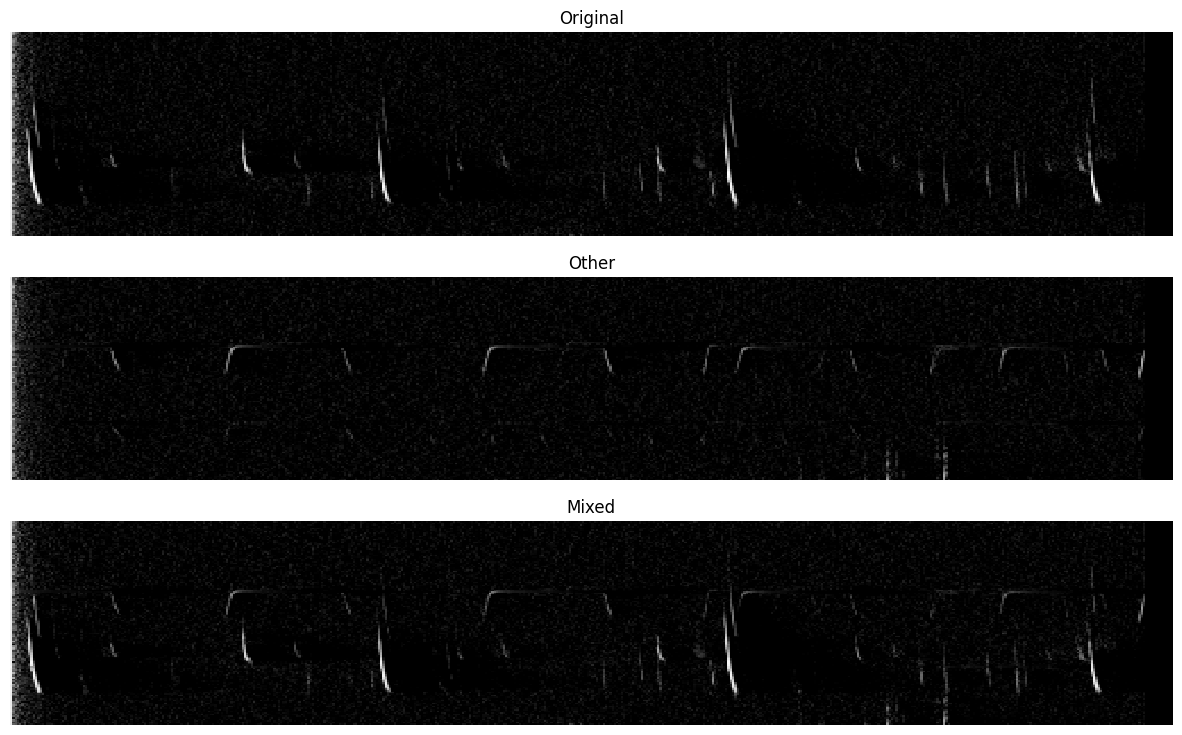

In [10]:
fig, axs = plt.subplots(figsize=(15, 9), nrows=3, ncols=1)
dataset1.spectrogram.plot(ax=axs[0], cmap="grey", add_colorbar=False)
axs[0].set_title("Original")
axs[0].axis("off")
dataset2.spectrogram.plot(ax=axs[1], cmap="grey", add_colorbar=False)
axs[1].set_title("Other")
axs[1].axis("off")
mixed.spectrogram.plot(ax=axs[2], cmap="grey", add_colorbar=False)
axs[2].set_title("Mixed")
axs[2].axis("off");

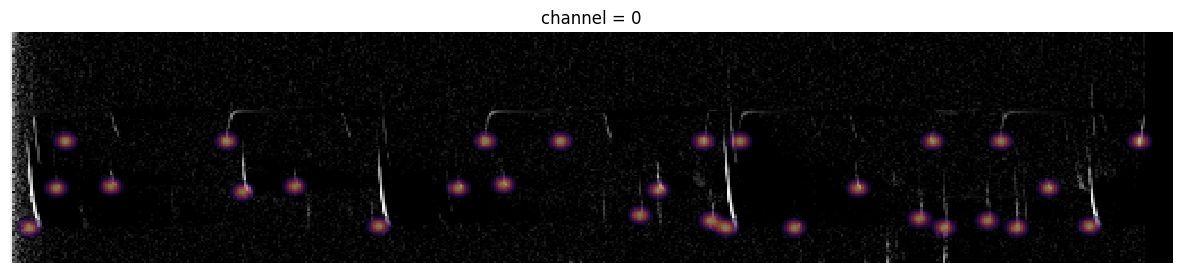

In [11]:
_, ax = plt.subplots(figsize=(15, 3))
mixed.spectrogram.plot(ax=ax, cmap="gray", add_colorbar=False)
mixed.detection.where(mixed.detection > 0.1).plot(
    ax=ax, alpha=0.5, cmap="magma", add_colorbar=False
)
ax.axis("off");

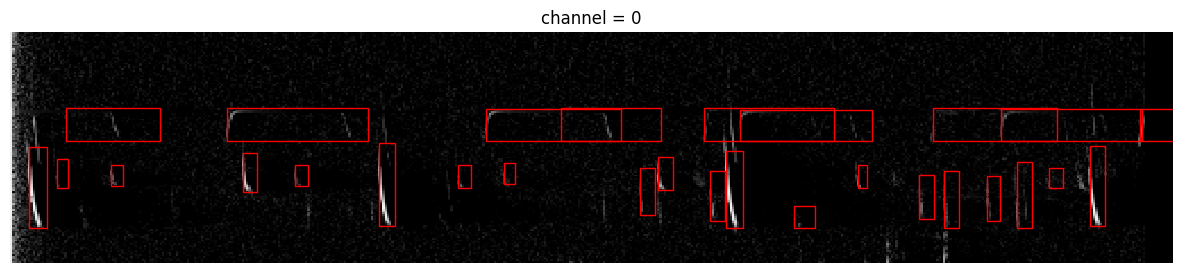

In [12]:
# Plot the grayscale spectrogram as the base layer
_, ax = plt.subplots(figsize=(15, 3))
mixed["spectrogram"].plot(ax=ax, cmap="grey", add_colorbar=False)
plot_bboxes(mixed["size"], ax=ax)
ax.axis("off");

# Add Echo

In [13]:
with_echo = add_echo(dataset1, delay=0.01, weight=0.3)

<Figure size 640x480 with 0 Axes>

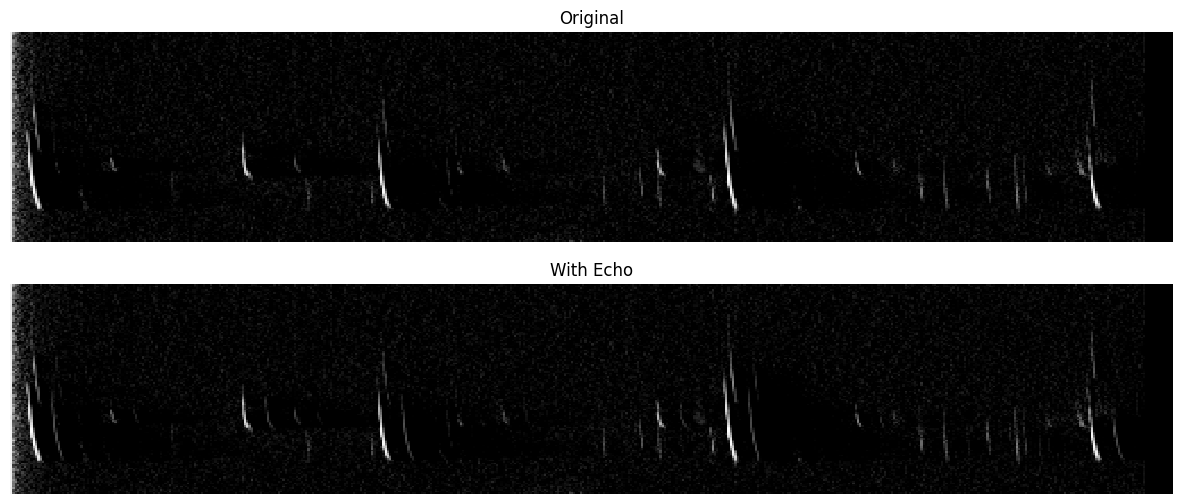

In [14]:
fig = plt.figure()
fig, axs = plt.subplots(figsize=(15, 6), nrows=2, ncols=1)
dataset1.spectrogram.plot(ax=axs[0], add_colorbar=False, cmap="grey")
axs[0].set_title("Original")
axs[0].axis("off")
ax2 = plt.subplot(2, 1, 2)
with_echo.spectrogram.plot(ax=axs[1], add_colorbar=False, cmap="grey")
axs[1].set_title("With Echo")
axs[1].axis("off");

# Select Random Subclip

In [15]:
subclip = select_random_subclip(dataset1, duration=0.3)

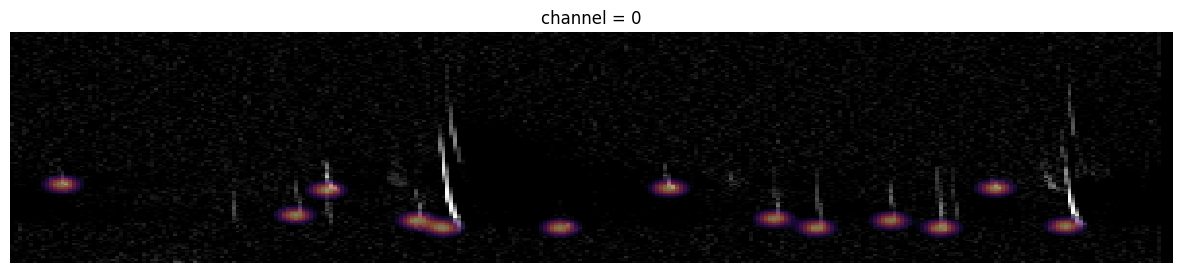

In [16]:
_, ax = plt.subplots(figsize=(15, 3))
subclip.spectrogram.plot(ax=ax, cmap="gray", add_colorbar=False)
subclip.detection.where(subclip.detection > 0.1).plot(
    ax=ax, cmap="magma", alpha=0.5, add_colorbar=False
)
ax.axis("off");

# Masked Time Axis

(np.float64(-0.0005000894307158887),
 np.float64(0.5115914940834045),
 np.float64(10031.12109375),
 np.float64(119604.9921875))

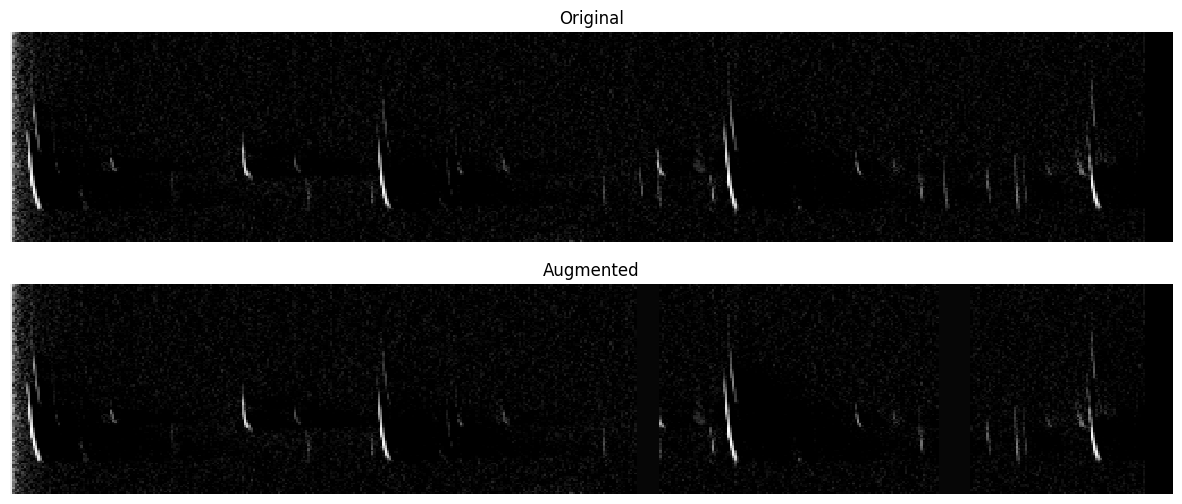

In [17]:
time_masked = mask_time(dataset1)
fig, axs = plt.subplots(figsize=(15, 6), nrows=2, ncols=1)
dataset1.spectrogram.plot(cmap="gray", add_colorbar=False, ax=axs[0])
axs[0].set_title("Original")
axs[0].axis("off")
time_masked.spectrogram.plot(cmap="gray", add_colorbar=False, ax=axs[1])
axs[1].set_title("Augmented")
axs[1].axis("off")

# Masked Frequency Axis

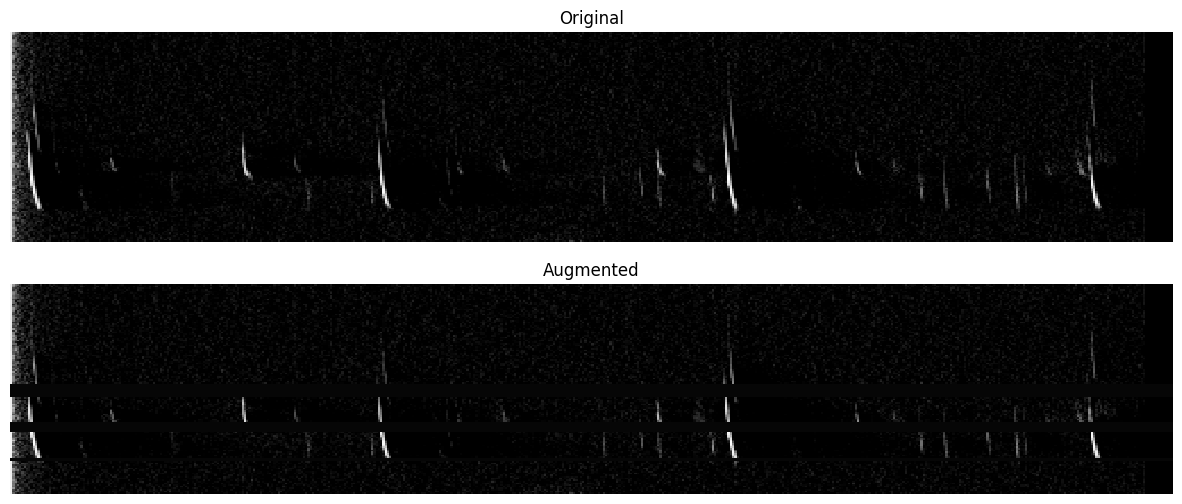

In [18]:
freq_masked = mask_frequency(dataset1)
fig, axs = plt.subplots(figsize=(15, 6), nrows=2, ncols=1)
dataset1.spectrogram.plot(cmap="gray", add_colorbar=False, ax=axs[0])
axs[0].set_title("Original")
axs[0].axis("off")
freq_masked.spectrogram.plot(cmap="gray", add_colorbar=False, ax=axs[1])
axs[1].set_title("Augmented")
axs[1].axis("off");

# Warp

In [74]:
warped = warp_spectrogram(dataset1)

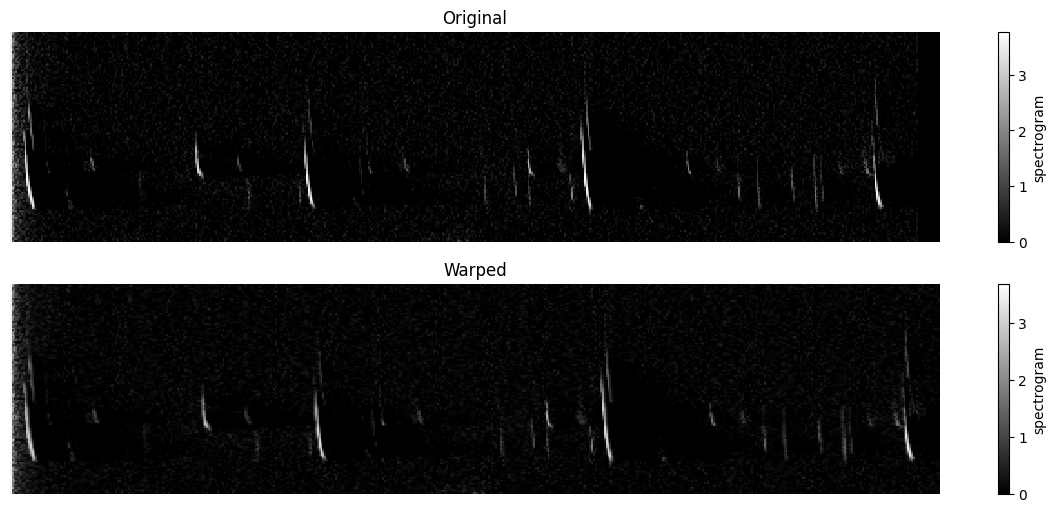

In [75]:
fig, axs = plt.subplots(figsize=(15, 6), nrows=2, ncols=1)
dataset1.spectrogram.plot(cmap="grey", add_colorbar=True, ax=axs[0])
axs[0].set_title("Original")
axs[0].axis("off")
warped.spectrogram.plot(cmap="grey", add_colorbar=True, ax=axs[1])
axs[1].set_title("Warped")
axs[1].axis("off");

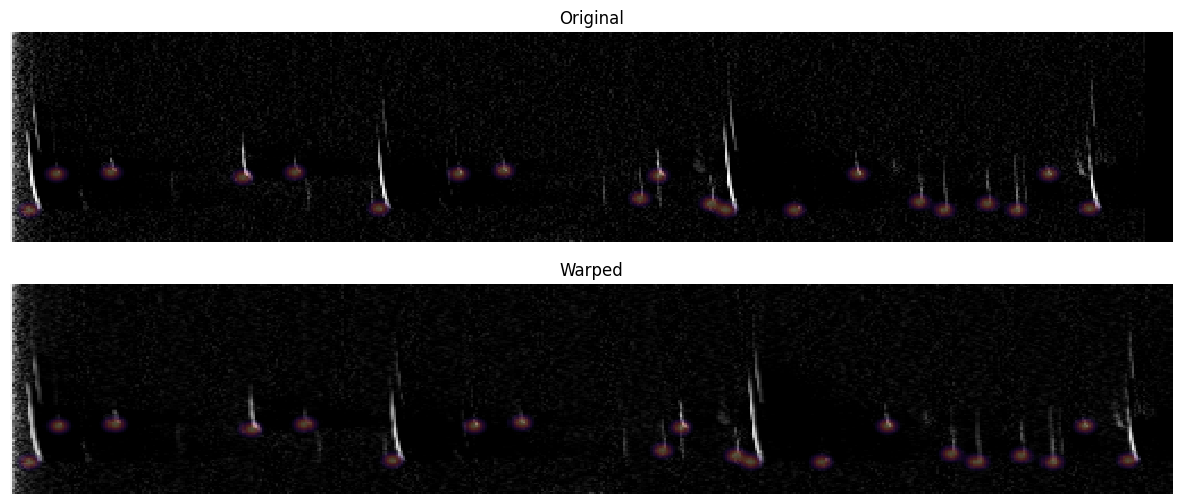

In [76]:
fig, axs = plt.subplots(figsize=(15, 6), nrows=2, ncols=1)
dataset1.spectrogram.plot(cmap="gray", add_colorbar=False, ax=axs[0])
dataset1.detection.where(dataset1.detection > 0.1).plot(cmap="magma", add_colorbar=False, alpha=0.3, ax=axs[0])
axs[0].set_title("Original")
axs[0].axis("off")
warped.spectrogram.plot(cmap="gray", add_colorbar=False, ax=axs[1])
warped.detection.where(warped.detection > 0.1).plot(cmap="magma", add_colorbar=False, alpha=0.3, ax=axs[1])
axs[1].set_title("Warped")
axs[1].axis("off");

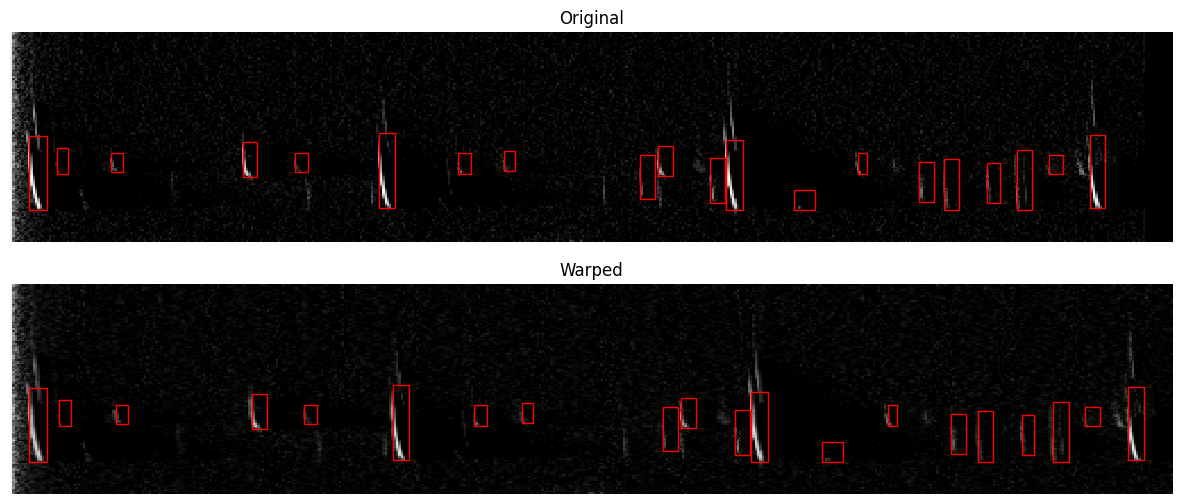

In [77]:
fig, axs = plt.subplots(figsize=(15, 6), nrows=2, ncols=1)
dataset1.spectrogram.plot(cmap="gray", add_colorbar=False, ax=axs[0])
plot_bboxes(dataset1["size"], ax=axs[0])
axs[0].set_title("Original")
axs[0].axis("off")
warped.spectrogram.plot(cmap="gray", add_colorbar=False, ax=axs[1])
plot_bboxes(warped["size"], ax=axs[1])
axs[1].set_title("Warped")
axs[1].axis("off");